In [44]:
# import and downlaod anything required for yolov5 image detection with pytorch
# Make sure to use a new environment for this as I did not check compabiliy with the rest of the project

#!pip uninstall torch torchvision -y
#!pip install -r ai/traffic_light_detection/yolo5_requirements.txt
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu117
#!pip install pytorch-lightning
!pip install flask


  Using cached Flask-2.3.2-py3-none-any.whl (96 kB)
  Using cached Werkzeug-2.3.4-py3-none-any.whl (242 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)


Using cache found in C:\Users\Test 2/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-5 Python-3.11.3 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 480x640 6 cars, 9 traffic lights
Speed: 6.5ms pre-process, 24.6ms inference, 2.0ms NMS per image at shape (1, 3, 480, 640)


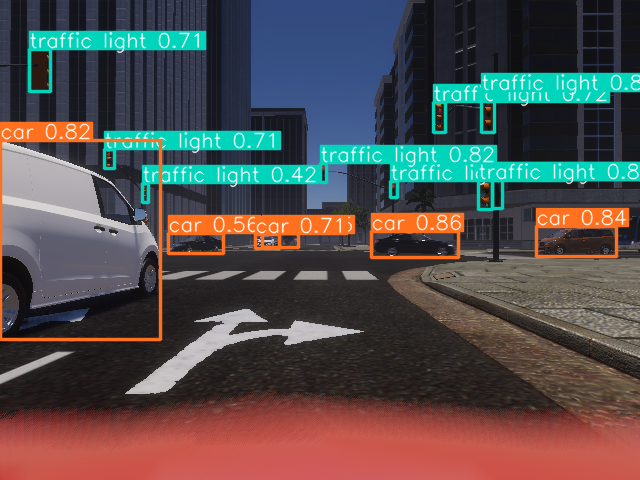

In [12]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # Currently not working, on GPU, but should work if implemented correctly

# Image
im = 'ai/traffic_light_detection/testImgs/CapturedImage2.png'

# Inference
results = model(im)

print(results)
results.pandas().xyxy[0]

#show only the traffic lights
results.pandas().xyxy[0][results.pandas().xyxy[0]['name'] == 'traffic light']

#show the image with the bounding boxes
results.show()

# crop the image to the bounding box of the traffic light
from PIL import Image
import numpy as np

for i in range(len(results.pandas().xyxy[0][results.pandas().xyxy[0]['name'] == 'traffic light'])):
    bbox = results.pandas().xyxy[0][results.pandas().xyxy[0]['name'] == 'traffic light'].values[i][0:4]
    copped = Image.open(im)
    copped = copped.crop(bbox)
    copped.save('ai/traffic_light_detection/testImgs/CroppedImage' + str(i) + '.png')

In [13]:
#TODO: Creates jumping videos as naming of image subfolders is stupid

def create_video(data_path):
    # creating a mp4 file from the images
    import cv2
    import os
    import torch

    #import a statusbar
    from tqdm import tqdm

    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

    image_folder = data_path
    video_name = 'inputVideo.avi'
    images = []
    #images are stored in subfolders, alyways taking the ones named "CapturedImage2.png"
    for path, subdirs, files in os.walk(image_folder):
        for name in files:
            if name.endswith("CapturedImage2.png"):
                images.append(os.path.join(path, name))

    print(f"Num of images: {len(images)}")
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 15, (width,height))

    maxImages = 400

    for image in images:
        if images.index(image) > maxImages:
            break
        results = model(image)
        video.write( results.render()[0])
        # add a statusbar to be seen in jupyter notebook
        tqdm._instances.clear()

        
    cv2.destroyAllWindows()
    video.release()


create_video('C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/IMG')

Using cache found in C:\Users\Test 2/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-5 Python-3.11.3 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Num of images: 1306


In [14]:
#put all images from the subfolders into a single folder
import os
import shutil

def move_files(data_path):
    # moving all images from the subfolders into a single folder
    #Add the name of the subfolder to the image name
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            if name.endswith("CapturedImage2.png"):
                shutil.move(os.path.join(path, name), os.path.join(data_path, name.replace('CapturedImage2.png', path.split('\\')[-1] + 'CapturedImage2.png')))


#move_files('C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/IMG')

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_red_and_yellow(img, Threshold=0.01):
    """
    detect red and yellow
    :param img:
    :param Threshold:
    :return:
    """

    desired_dim = (30, 90)  # width, height
    img = cv2.resize(np.array(img), desired_dim, interpolation=cv2.INTER_LINEAR)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red1 = np.array([170, 70, 50])
    upper_red1 = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)

    # defining the Range of yellow color
    lower_yellow = np.array([21, 39, 64])
    upper_yellow = np.array([40, 255, 255])
    mask2 = cv2.inRange(img_hsv, lower_yellow, upper_yellow)

    # red pixels' mask
    mask = mask0 + mask1 + mask2

    # Compare the percentage of red values
    rate = np.count_nonzero(mask) / (desired_dim[0] * desired_dim[1])

    if rate > Threshold:
        return True
    else:
        return False
    
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def read_traffic_lights_object(image, boxes, scores, classes, max_boxes_to_draw=20, min_score_thresh=0.5,
                               traffic_ligth_label=10):
    im_width, im_height = image.size
    stop_flag = False
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores[i] > min_score_thresh and classes[i] == traffic_ligth_label:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            crop_img = image.crop((left, top, right, bottom))

            if detect_red_and_yellow(crop_img):
                stop_flag = True

    return stop_flag

def plot_origin_image(image_np, boxes, classes, scores, category_index):
    # Size of the output images.
    IMAGE_SIZE = (12, 8)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        min_score_thresh=.5,
        use_normalized_coordinates=True,
        line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

    # save augmented images into hard drive
    # plt.savefig( 'output_images/ouput_' + str(idx) +'.png')
    plt.show()

def detect_traffic_lights_old(PATH_TO_TEST_IMAGES_DIR, MODEL_NAME, Num_images, plot_flag=False):
    """
    Detect traffic lights and draw bounding boxes around the traffic lights
    :param PATH_TO_TEST_IMAGES_DIR: testing image directory
    :param MODEL_NAME: name of the model used in the task
    :return: commands: True: go, False: stop
    """

    # --------test images------
    TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'img_{}.jpg'.format(i)) for i in range(1, Num_images + 1)]


    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            for image_path in TEST_IMAGE_PATHS:
                image = Image.open(image_path)

                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})

                stop_flag = read_traffic_lights_object(image, np.squeeze(boxes), np.squeeze(scores),
                                                       np.squeeze(classes).astype(np.int32))
                if stop_flag:
                    # print('{}: stop'.format(image_path))  # red or yellow
                    commands.append(False)
                    cv2.putText(image_np, 'Stop', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
                else:
                    # print('{}: go'.format(image_path))
                    commands.append(True)
                    cv2.putText(image_np, 'Go', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

                # Visualization of the results of a detection.
                if plot_flag:
                    plot_origin_image(image_np, boxes, classes, scores, category_index)

    return commands

def filter_frontal_traffic_lights(images):
    # detect the color of the traffic light
    return images


def crop_out_traffic_lights(image, model, confidence_threshold):
    # Change image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    results = model(image)
    results.show()


    # crop the image to create multiple images of traffic lights
    copped_images = []
    stats = []
    for i in range(len(results.xyxy[0])):
        xmin, ymin, xmax, ymax, confidence, class_id = results.xyxy[0][i]
        if class_id == 9 and confidence > confidence_threshold:
            copped_images.append(original[int(ymin):int(ymax), int(xmin):int(xmax)])
            stats.append((xmin, ymin, xmax-xmin, ymax-ymax))
    
    return copped_images, stats

def save_images(images, path):
    for i in range(len(images)):
        # convert to BGR
        images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
        cv2.imwrite(path + 'sub' + str(i) + '.png', images[i])

def add_to_training_data(images, stats, path):
    import pandas as pd
    stats = pd.DataFrame([for row in stats row.astype(float)], columns=['xmin', 'ymin', 'width', 'height'])
    stats_data = pd.read_csv(path + 'traffic_lights.csv')
    for i in range(len(images)):
        # convert to BGR
        images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
        cv2.imwrite(path + 'sub' + str(i) + '.png', images[i])
        stats_data = pd.concat([stats_data, 
                                pd.DataFrame(stats[i][0],stats[i][1],stats[i][2], stats[i][3])])
    stats_data.to_csv(path + 'traffic_lights.csv')


if __name__ == "__main__":
    import torch
    image = cv2.imread('C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/IMG/sub1231CapturedImage2.png')
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

    trafficLights, stats = crop_out_traffic_lights(image, model, confidence_threshold=0.3)
    add_to_training_data(trafficLights, stats, 'C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/traffic_lights/')
    #save_images(trafficLights, 'C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/traffic_lights/')
    frontalTrafficLights = filter_frontal_traffic_lights(trafficLights)
    


SyntaxError: invalid syntax (3728380957.py, line 169)

In [7]:
# a fuction to find which color is more dominant in the image - red or green
def find_primary_color(image):
    # convert image to HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # define range of red color in HSV
    lower_red = np.array([157, 61, 102])
    upper_red = np.array([180, 255, 255])

    # define range of green color in HSV
    lower_green = np.array([50, 50, 50])
    upper_green = np.array([85, 255, 255])

    # define range of green color in HSV
    lower_yellow = np.array([22, 139, 98])
    upper_yellow = np.array([41, 255, 255])

    # Threshold the HSV image to get only red colors
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # Threshold the HSV image to get only green colors
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Threshold the HSV image to get only yellow colors
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # count the number of red and green pixels
    red_pixels = cv2.countNonZero(mask_red)
    green_pixels = cv2.countNonZero(mask_green)
    yellow_pixels = cv2.countNonZero(mask_yellow)

    print('red pixels: {}'.format(red_pixels), 'green pixels: {}'.format(green_pixels), 'yellow pixels: {}'.format(yellow_pixels))

    

    # return the dominant color
    if red_pixels > green_pixels and red_pixels > yellow_pixels:
        return 'red'
    elif green_pixels > red_pixels and green_pixels > yellow_pixels:
        return 'green'
    elif yellow_pixels > red_pixels and yellow_pixels > green_pixels:
        return 'yellow'
    else:
        return None
    
# a function to detect the color of the traffic light
def crop_out_traffic_lights(image, model, confidence_threshold):
    # Change image to numpy array
    image = np.array(image)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    results = model(image)

    cv2.imshow('image', results.render()[0])
    cv2.waitKey(0)


    # crop the image to create multiple images of traffic lights
    traffic_lights = []
    for i in range(len(results.xyxy[0])):
        xmin, ymin, xmax, ymax, confidence, class_id = results.xyxy[0][i]
        if class_id == 9 and confidence > confidence_threshold:
            
            image = original[int(ymin):int(ymax), int(xmin):int(xmax)]
            traffic_lights.append({"image" : image, "xmin" : xmin, "ymin" : ymin, "width" : xmax - xmin, "height" : ymax - ymin})
        print("adding element to traffic_lights")
    
    return traffic_lights

def filter_middle_images(images, width, left, right):
    # only keep the images that are about the middle of image
    filtered_images = []
    for image in images:
        if image["xmin"] > width * left and image["xmin"] < width * (1 - right):
            filtered_images.append(image)

    return filtered_images

import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

image = cv2.imread('C:/Development/task3_duetsch_sodamin/data/training/alwaysTurnRight/IMG/sub945CapturedImage2.png')
# show the image

#show shape of image
print(image.shape)

traffic_lights = crop_out_traffic_lights(image, model, confidence_threshold=0.3)
filtered_images = filter_middle_images(traffic_lights, image.shape[1], 0.2, 0.2)
i = 0
for image in filtered_images:
    # save images
    i = i + 1
    cv2.imwrite('C:/Development/task3_duetsch_sodamin/data/' + str(i) + '.png', image["image"])
    print(find_primary_color(image["image"]))
    cv2.imshow("image", image["image"])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using cache found in C:\Users\Test 2/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-5 Python-3.11.3 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


(480, 640, 3)
adding element to traffic_lights
adding element to traffic_lights
adding element to traffic_lights
adding element to traffic_lights
adding element to traffic_lights
red pixels: 0 green pixels: 11 yellow pixels: 0
green
red pixels: 0 green pixels: 0 yellow pixels: 0
None
